## Imports

In [1]:
import json
import numpy as np
import pandas as pd

from math import log10
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import ScalarMappable
from dateutil import parser as dateparser

from prosper import Flare, CME, sepprobs, sepchars

## Flare/CME characteristics

In [2]:
input_filepath = "examples/example.csv"

In [3]:
df = pd.read_csv(input_filepath,
                 header=0,
                 parse_dates=[0, 4])
df

,flare_date,flare_longitude,flare_magnitude,flare_class,cme_date,cme_speed,cme_width,peak_flux_10,peak_flux_30,peak_flux_100,SEP
0,2011-03-07 19:43:00,48.0,0.000037,M3.7,2011-03-07 20:00:00,2125,360,50.386000,5.185300,0.162110,True
1,2022-08-17 13:26:00,25.0,0.000020,M2.0,2022-08-17 14:36:34,901,360,0.727388,0.456366,0.428688,False
2,2021-11-01 00:57:00,48.0,0.000015,M1.5,2021-11-01 02:00:06,753,274,28.950766,16.265814,7.327305,False
3,2015-03-09 23:29:00,-39.0,0.000058,M5.8,2015-03-10 00:00:05,995,360,0.588030,0.233610,0.084903,False
4,2022-12-01 07:04:00,35.0,0.000010,M1.0,2022-12-01 07:48:05,813,115,1.109347,0.465356,0.436371,False
...,...,...,...,...,...,...,...,...,...,...,...
58,2014-12-17 04:25:00,-8.0,0.000087,M8.7,2014-12-17 05:00:05,587,360,0.654370,0.336540,0.083624,False
59,2011-06-07 06:16:00,53.0,0.000025,M2.5,2011-06-07 06:49:00,1255,360,72.866000,25.841000,4.528100,True
60,2014-08-01 18:00:00,-13.0,0.000015,M1.5,2014-08-01 18:36:05,789,360,0.636170,0.543210,0.143240,False
61,2013-09-29 21:43:00,33.0,0.000001,C1.2,2013-09-29 22:12:00,1179,360,181.810000,8.573000,0.180260,True


In [4]:
ENERGIES = [10, 30, 100, 300]
I_THRESHOLDS = {10: 10, 30: 3, 100: 1, 300: 0.3}
I_FILL_VALUE = -9999

In [5]:
for energy in ENERGIES:
    try:
        df[f"peak_flux_{energy}"]
    except KeyError:
        df[f"peak_flux_{energy}"] = [I_FILL_VALUE]*len(df)

    df[f"SEP_{energy}"] = df[f"peak_flux_{energy}"] > I_THRESHOLDS[energy]

In [6]:
df["triggers"] = [
    {
        "flare": Flare(row["flare_longitude"],
                       row["flare_magnitude"],
                       row["flare_class"],
                       row["flare_date"].to_pydatetime())
                 if not pd.isna(row["flare_date"]) else None,
        "cme": CME(row["cme_width"],
                   row["cme_speed"],
                   row["cme_date"].to_pydatetime())
               if not pd.isna(row["cme_date"]) else None
    }
    for _, row in df.iterrows()
]

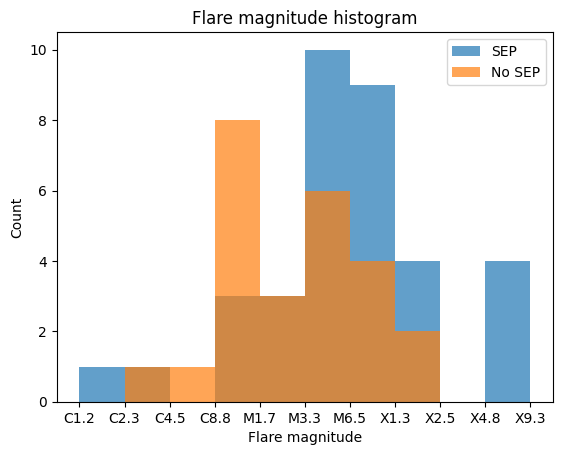

In [7]:
nbins = 10
magnitudes_log_sep = [log10(t["flare"].magnitude) for t in df[df["SEP_10"]]["triggers"] if t["flare"] is not None]
magnitudes_log_nosep = [log10(t["flare"].magnitude) for t in df[~df["SEP_10"]]["triggers"] if t["flare"] is not None]
bins = list(np.arange((min_value := min(magnitudes_log_sep + magnitudes_log_nosep)), (max_value := max(magnitudes_log_sep + magnitudes_log_nosep)) + (bin_width := ((max_value - min_value)/nbins)), bin_width))
plt.title("Flare magnitude histogram")
plt.hist(magnitudes_log_sep, bins, alpha=0.7, label="SEP")
plt.hist(magnitudes_log_nosep, bins, alpha=0.7, label="No SEP")
plt.xlabel("Flare magnitude")
plt.ylabel("Count")
mp_c_map = {"-04": "X", "-05": "M", "-06": "C", "-07": "B", "-08": "A"}
f_xticks_label = lambda x: f"{mp_c_map[(parts := f'{10**x:.1E}'.split('E'))[1]]}{parts[0]}"
plt.xticks(bins, labels=([f_xticks_label(b) for b in bins] if f_xticks_label is not None else None))
plt.legend()
plt.show()

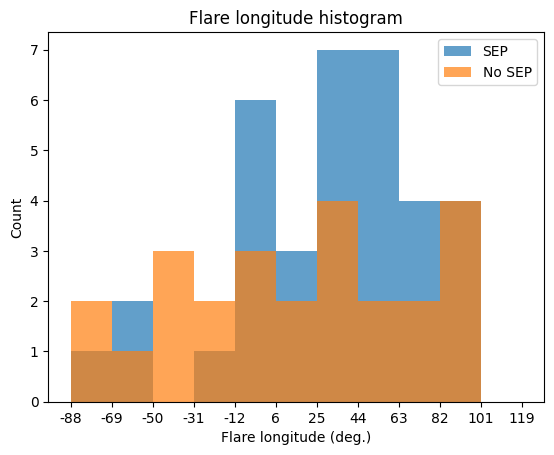

In [8]:
nbins = 10
longitudes_sep = [t["flare"].longitude for t in df[df["SEP_10"]]["triggers"] if t["flare"] is not None]
longitudes_nosep = [t["flare"].longitude for t in df[~df["SEP_10"]]["triggers"] if t["flare"] is not None]
bins = list(np.arange((min_value := min(longitudes_sep + longitudes_nosep)), (max_value := max(longitudes_sep + longitudes_nosep)) + (bin_width := ((max_value - min_value)/nbins)), bin_width))
plt.title("Flare longitude histogram")
plt.hist(longitudes_sep, bins, alpha=0.7, label="SEP")
plt.hist(longitudes_nosep, bins, alpha=0.7, label="No SEP")
plt.xlabel("Flare longitude (deg.)")
plt.ylabel("Count")
plt.xticks(bins, labels=[str(int(b)) for b in bins])
plt.legend()
plt.show()

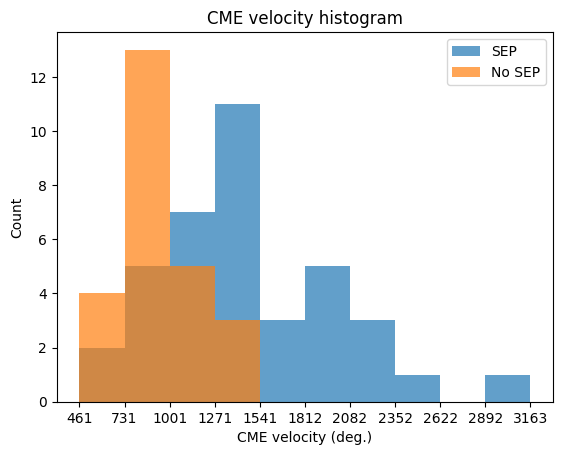

In [9]:
nbins = 10
speeds_sep = [t["cme"].velocity for t in df[df["SEP_10"]]["triggers"] if t["cme"] is not None]
speeds_nosep = [t["cme"].velocity for t in df[~df["SEP_10"]]["triggers"] if t["cme"] is not None]
bins = list(np.arange((min_value := min(speeds_sep + speeds_nosep)), (max_value := max(speeds_sep + speeds_nosep)) + (bin_width := ((max_value - min_value)/nbins)), bin_width))
plt.title("CME velocity histogram")
plt.hist(speeds_sep, bins, alpha=0.7, label="SEP")
plt.hist(speeds_nosep, bins, alpha=0.7, label="No SEP")
plt.xlabel("CME velocity (deg.)")
plt.ylabel("Count")
plt.xticks(bins, labels=[str(int(b)) for b in bins])
plt.legend()
plt.show()

## PROSPER run

### SEP Probability

In [10]:
prosper_results = sepprobs(df["triggers"])
df["SEP probabilities"] = prosper_results["sep_probabilities"]

In [11]:
PROB_THRESHOLDS = {10: 0.26, 30: 0.2, 100: 0.15, 300: 0.12}

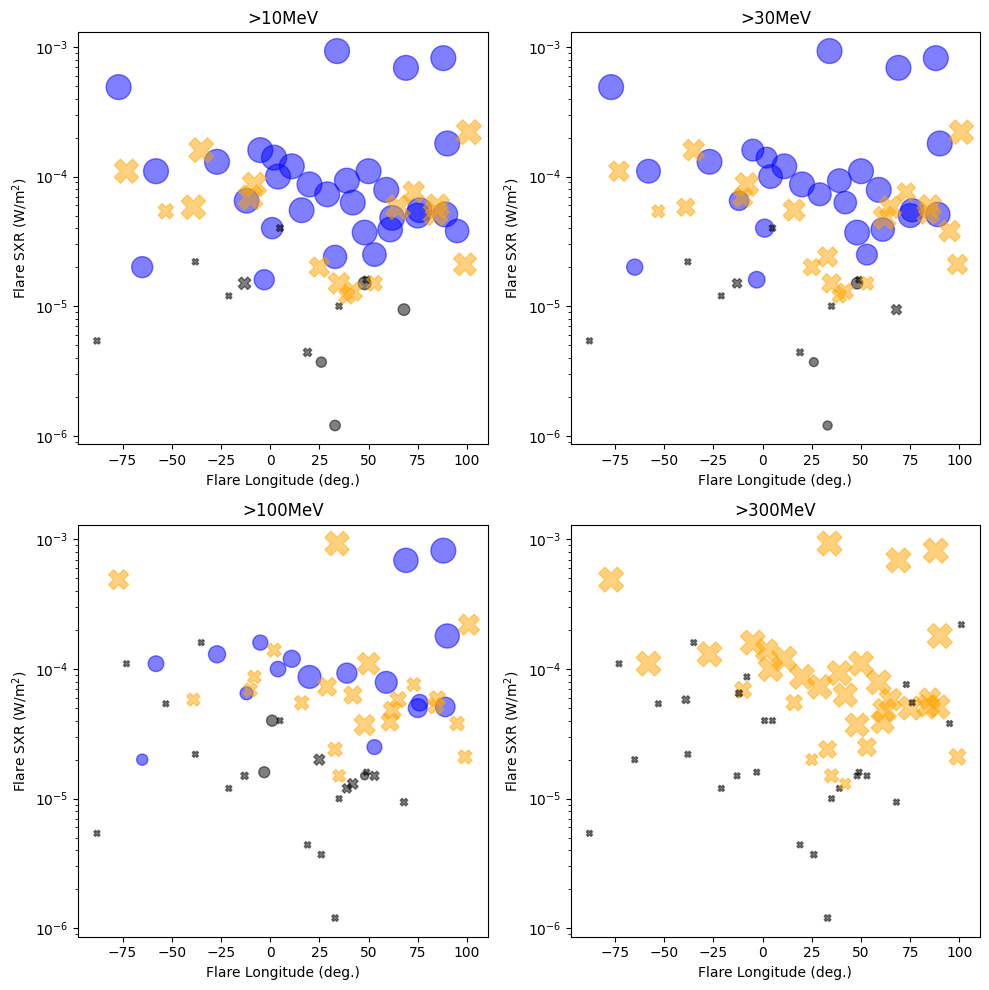

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for energy, ax in zip(ENERGIES, axs.flatten()):
    probs_sep = [sp[f"probability_{energy}"] for sp in df[df[f"SEP_{energy}"]]["SEP probabilities"]]
    magnitudes_sep = [t["flare"].magnitude if t["flare"] is not None else None for t in df[df[f"SEP_{energy}"]]["triggers"]]
    longitudes_sep = [t["flare"].longitude if t["flare"] is not None else None for t in df[df[f"SEP_{energy}"]]["triggers"]]
    ax.scatter(longitudes_sep,
               magnitudes_sep,
               s=[(p if p is not None else 0)*300 + 20 for p in probs_sep],
               c=["black" if p is None or p < PROB_THRESHOLDS[energy] else "blue" for p in probs_sep],
               marker="o",
               alpha=0.5)
    
    probs_nosep = [sp[f"probability_{energy}"] for sp in df[~df[f"SEP_{energy}"]]["SEP probabilities"]]
    magnitudes_nosep = [t["flare"].magnitude if t["flare"] is not None else None for t in df[~df[f"SEP_{energy}"]]["triggers"]]
    longitudes_nosep = [t["flare"].longitude if t["flare"] is not None else None for t in df[~df[f"SEP_{energy}"]]["triggers"]]
    ax.scatter(longitudes_nosep,
               magnitudes_nosep,
               s=[(p if p is not None else 0)*300 + 20 for p in probs_nosep],
               c=["black" if p is None or p < PROB_THRESHOLDS[energy] else "orange" for p in probs_nosep],
               marker="X",
               alpha=0.5)
    
    ax.set_ylabel(r"Flare SXR (W/m$^2$)")
    ax.set_yscale("log")
    ax.set_xlabel("Flare Longitude (deg.)")

    ax.set_title(f">{energy}MeV")

plt.tight_layout()
plt.show()

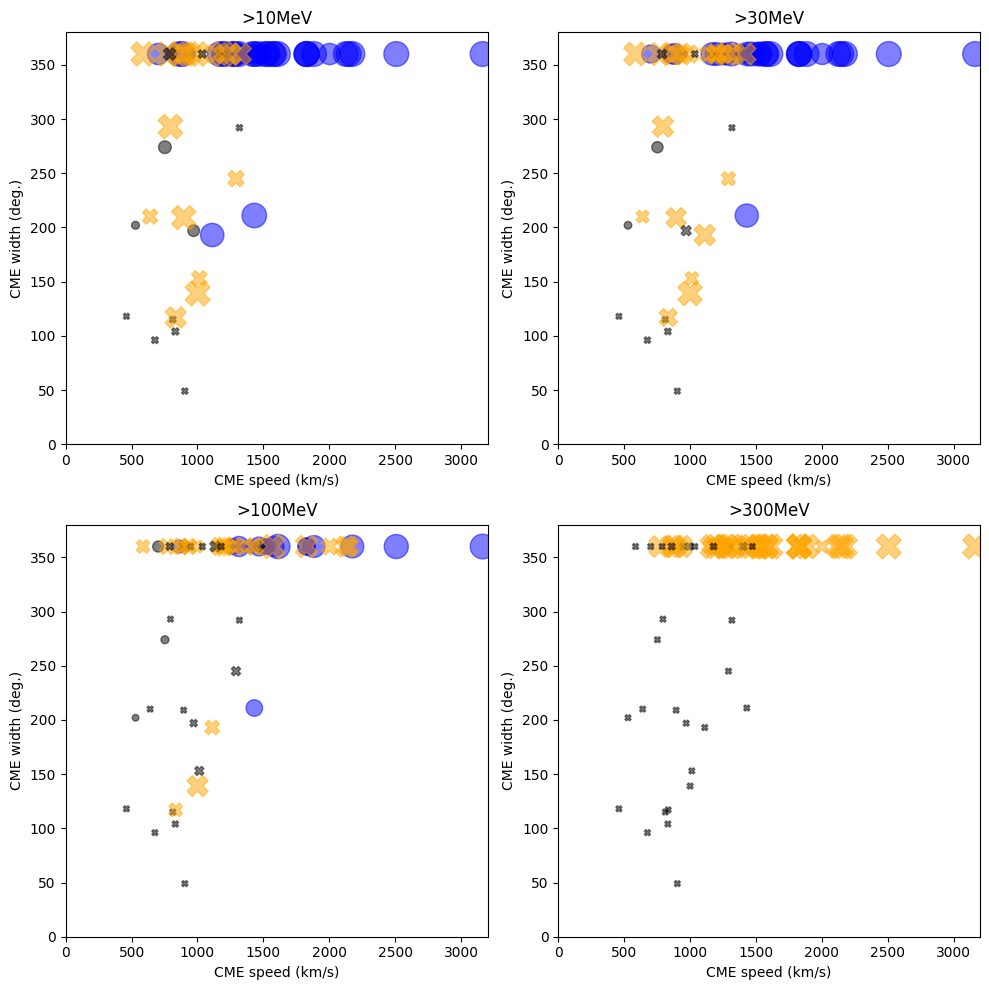

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for energy, ax in zip(ENERGIES, axs.flatten()):
    probs_sep = [sp[f"probability_{energy}"] for sp in df[df[f"SEP_{energy}"]]["SEP probabilities"]]
    speeds_sep = [t["cme"].velocity if t["cme"] is not None else None for t in df[df[f"SEP_{energy}"]]["triggers"]]
    widths_sep = [t["cme"].width if t["cme"] is not None else None for t in df[df[f"SEP_{energy}"]]["triggers"]]
    ax.scatter(speeds_sep,
               widths_sep,
               s=[(p if p is not None else 0)*300 + 20 for p in probs_sep],
               c=["black" if p is None or p < PROB_THRESHOLDS[energy] else "blue" for p in probs_sep],
               marker="o",
               alpha=0.5)
    probs_nosep = [sp[f"probability_{energy}"] for sp in df[~df[f"SEP_{energy}"]]["SEP probabilities"]]
    speeds_nosep = [t["cme"].velocity if t["cme"] is not None else None for t in df[~df[f"SEP_{energy}"]]["triggers"]]
    widths_nosep = [t["cme"].width if t["cme"] is not None else None for t in df[~df[f"SEP_{energy}"]]["triggers"]]
    ax.scatter(speeds_nosep,
               widths_nosep,
               s=[(p if p is not None else 0)*300 + 20 for p in probs_nosep],
               c=["black" if p is None or p < PROB_THRESHOLDS[energy] else "orange" for p in probs_nosep],
               marker="X",
               alpha=0.5)
    
    ax.set_ylim(0, 380)
    ax.set_ylabel("CME width (deg.)")
    ax.set_xlim(0, 3200)
    ax.set_xlabel("CME speed (km/s)")

    ax.set_title(f">{energy}MeV")

plt.tight_layout()
plt.show()

/tmp/ipykernel_6213/2213683487.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


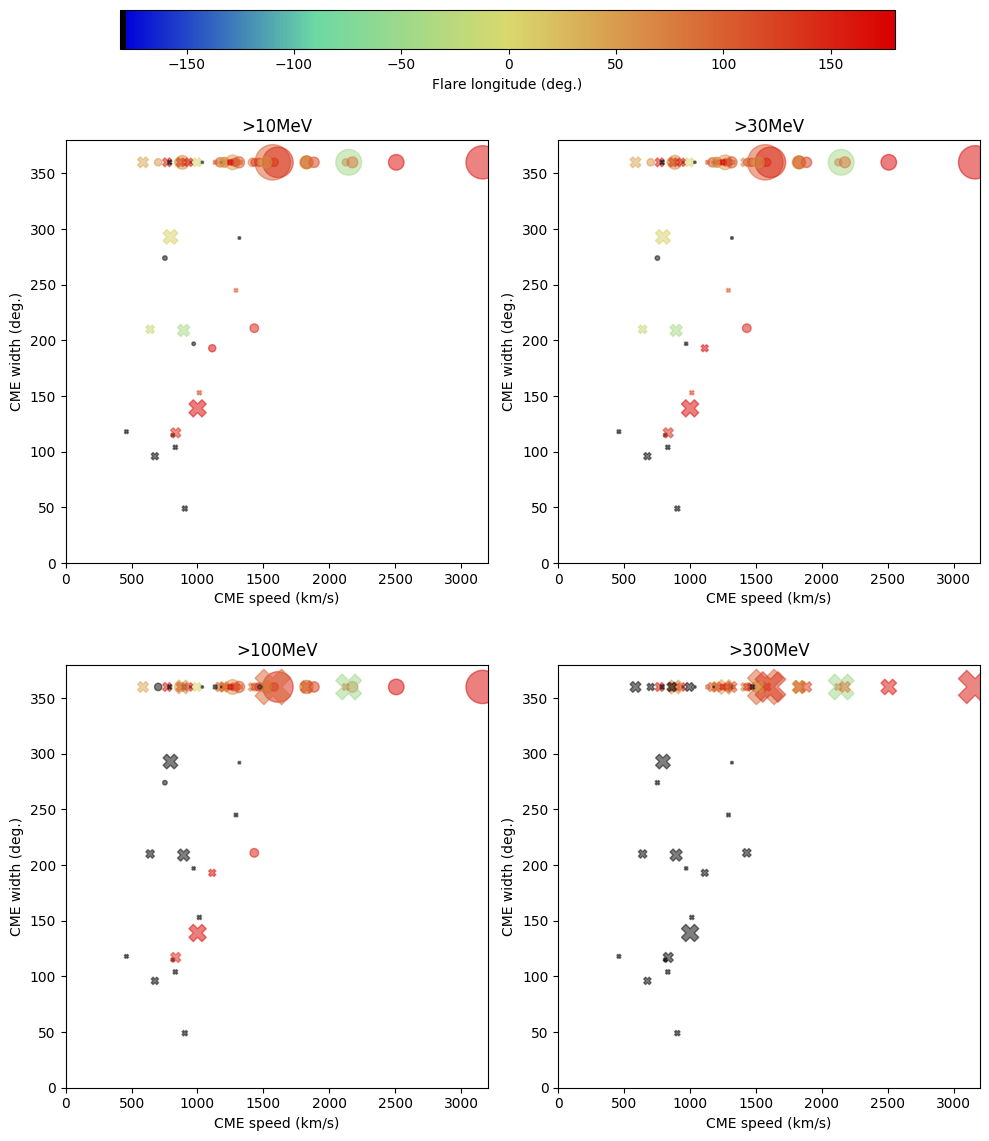

In [14]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

cdict = {
    "red": [
        (0, 0, 0),
        (1/255, 0, 0),
        (.5, .85, .85),
        (1, .85, .85)
    ],
    "green": [
        (0, 0, 0),
        (1/255, 0, 0),
        (.25, .85, .85),
        (.5, .85, .85),
        (1, 0, 0)
    ],
    "blue": [
        (0, 0, 0),
        (1/255, 0, 0),
        (2/255, .85, .85),
        (1, 0, 0)
    ]
}

cmap = LinearSegmentedColormap("Custom cmap", cdict)

for energy, ax in zip(ENERGIES, axs.flatten()):
    probs_sep = [sp[f"probability_{energy}"] for sp in df[df[f"SEP_{energy}"]]["SEP probabilities"]]
    speeds_sep = [t["cme"].velocity if t["cme"] is not None else None for t in df[df[f"SEP_{energy}"]]["triggers"]]
    widths_sep = [t["cme"].width if t["cme"] is not None else None for t in df[df[f"SEP_{energy}"]]["triggers"]]
    magnitudes_sep = [t["flare"].magnitude if t["flare"] is not None else None for t in df[df[f"SEP_{energy}"]]["triggers"]]
    longitudes_sep = [t["flare"].longitude if t["flare"] is not None else None for t in df[df[f"SEP_{energy}"]]["triggers"]]
    ax.scatter(speeds_sep,
               widths_sep,
               s=[mag*7e5 if mag is not None else 0 for mag in magnitudes_sep],
               c=[-181 if p is None or p < PROB_THRESHOLDS[energy] else long for p, long in zip(probs_sep, longitudes_sep)],
               cmap=cmap,
               marker="o",
               alpha=0.5)
    probs_nosep = [sp[f"probability_{energy}"] for sp in df[~df[f"SEP_{energy}"]]["SEP probabilities"]]
    speeds_nosep = [t["cme"].velocity if t["cme"] is not None else None for t in df[~df[f"SEP_{energy}"]]["triggers"]]
    widths_nosep = [t["cme"].width if t["cme"] is not None else None for t in df[~df[f"SEP_{energy}"]]["triggers"]]
    magnitudes_nosep = [t["flare"].magnitude if t["flare"] is not None else None for t in df[~df[f"SEP_{energy}"]]["triggers"]]
    longitudes_nosep = [t["flare"].longitude if t["flare"] is not None else None for t in df[~df[f"SEP_{energy}"]]["triggers"]]
    ax.scatter(speeds_nosep,
               widths_nosep,
               s=[mag*7e5 if mag is not None else 0 for mag in magnitudes_nosep],
               c=[-181 if p is None or p < PROB_THRESHOLDS[energy] else long for p, long in zip(probs_nosep, longitudes_nosep)],
               cmap=cmap,
               marker="X",
               alpha=0.5)
    
    ax.set_ylim(0, 380)
    ax.set_ylabel("CME width (deg.)")
    ax.set_xlim(0, 3200)
    ax.set_xlabel("CME speed (km/s)")

    ax.set_title(f">{energy}MeV")

sm = ScalarMappable(cmap=cmap)
sm.set_clim(-181, 180)
fig.colorbar(sm, ax=axs, location="bottom", anchor=(0, 12.3), label="Flare longitude (deg.)")
plt.tight_layout()
plt.show()

In [15]:
def metrics(series_real, series_predicted):
    invalids = 0
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for real, predicted in zip(series_real, series_predicted):
        if real is None or predicted is None:
            invalids += 1
            continue
        if real == predicted == True:
            tp += 1
        elif real == predicted == False:
            tn += 1
        elif real == True and predicted == False:
            fn += 1
        elif real == False and predicted == True:
            fp += 1
    num_events = len(series_predicted)-invalids
    pod = tp/(tp + fn)
    far = fp/(tp + fp)
    pc = (tp + tn)/num_events
    hss = 2*(tp * tn - fp * fn)/((tp + fn)*(fn + tn)+(tp + fp)*(fp + tn))
    tss = tp/(tp + fn) - fp/(fp + tn)
    return (num_events, tp, fp, tn, fn, pod*100, far*100, pc*100, hss*100, tss*100)

In [16]:
prosper_results = sepprobs([{"flare": t["flare"], "cme": None} for t in df["triggers"]])
df["SEP probabilities flare"] = prosper_results["sep_probabilities"]

prosper_results = sepprobs([{"flare": None, "cme": t["cme"]} for t in df["triggers"]])
df["SEP probabilities CME"] = prosper_results["sep_probabilities"]

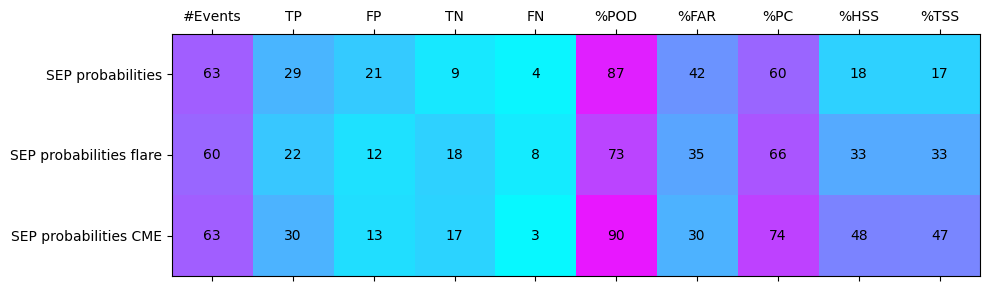

In [17]:
matrix = []
xlabels = ["#Events", "TP", "FP", "TN", "FN", "%POD", "%FAR", "%PC", "%HSS", "%TSS"]
ylabels = []

for colname in ["SEP probabilities", "SEP probabilities flare", "SEP probabilities CME"]:
    ylabels.append(colname)
    
    temp_df = df
    if "flare" in colname:
        temp_df = df[~pd.isna(df["flare_date"])]
    elif "CME" in colname:
        temp_df = df[~pd.isna(df["cme_date"])]
    
    real_values = temp_df["SEP"]
    predicted_values = [row[colname]["probability_10"] is not None and row[colname]["probability_10"] >= PROB_THRESHOLDS[10]
                        for _, row in temp_df.iterrows()]
    matrix.append(list(metrics(real_values, predicted_values)))

fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(matrix, vmin=0, vmax=100, cmap="cool")
ax.set_xticks(range(len(xlabels)), labels=xlabels)
ax.set_yticks(range(len(ylabels)), labels=ylabels)
for (i, j), z in np.ndenumerate(matrix):
    ax.text(j, i, int(z), ha="center", va="center")

plt.tight_layout()
plt.show()

### SEP characteristics

In [18]:
sepchars_results = sepchars(df["triggers"], df["SEP probabilities"])
df["SEP characteristics"] = sepchars_results["sep_characteristics"]

sepchars_results = sepchars([{"flare": t["flare"], "cme": None} for t in df["triggers"]], df["SEP probabilities flare"])
df["SEP characteristics flare"] = sepchars_results["sep_characteristics"]

sepchars_results = sepchars([{"flare": None, "cme": t["cme"]} for t in df["triggers"]], df["SEP probabilities CME"])
df["SEP characteristics CME"] = sepchars_results["sep_characteristics"]

In [19]:
def plot_obs_pred_pf(flavor = None):
    if flavor is None:
        suffix = ""
        suptitle = "Flare & CME"
    elif flavor == "flare":
        suffix = " flare"
        suptitle = "Flare"
    elif flavor == "cme":
        suffix = " CME"
        suptitle = "CME"

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

    for energy, ax in zip(ENERGIES, axs.flatten()):
        pf_observed = [row[f"peak_flux_{energy}"]
                    for _, row in df[df[f"SEP_{energy}"]].iterrows()
                    if row[f"SEP probabilities{suffix}"][f"probability_{energy}"] is not None and \
                        row[f"SEP probabilities{suffix}"][f"probability_{energy}"] >= PROB_THRESHOLDS[energy]]
        pf_predicted_50 = [row[f"SEP characteristics{suffix}"]["peak_flux"][str(energy)]["50cl"]
                        for _, row in df[df[f"SEP_{energy}"]].iterrows()
                        if row[f"SEP probabilities{suffix}"][f"probability_{energy}"] is not None and \
                            row[f"SEP probabilities{suffix}"][f"probability_{energy}"] >= PROB_THRESHOLDS[energy]]
        pf_predicted_90 = [row[f"SEP characteristics{suffix}"]["peak_flux"][str(energy)]["90cl"]
                        for _, row in df[df[f"SEP_{energy}"]].iterrows()
                        if row[f"SEP probabilities{suffix}"][f"probability_{energy}"] is not None and \
                            row[f"SEP probabilities{suffix}"][f"probability_{energy}"] >= PROB_THRESHOLDS[energy]]
        
        ax.scatter(pf_observed,
                pf_predicted_50,
                label="50% CL")
        ax.scatter(pf_observed,
                pf_predicted_90,
                label="90% CL")
        line_start = min(ax.get_ylim()[0], ax.get_xlim()[0])
        if line_start < 0:
            line_start = 1e-1
        line_end = max(ax.get_ylim()[1], ax.get_xlim()[1])
        if line_end < 0:
            line_end = 1e-1
        ax.plot([line_start, line_end],
                [line_start, line_end],
                color="red",
                linestyle="dashed",
                label="1:1")
        
        ax.set_yscale("log")
        ax.set_ylim(line_start, line_end)
        ax.set_ylabel("Predicted peak flux")
        ax.set_xscale("log")
        ax.set_xlim(line_start, line_end)
        ax.set_xlabel("Observed Predicted peak flux")

        ax.set_title(f">{energy}MeV")
        ax.legend()

    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

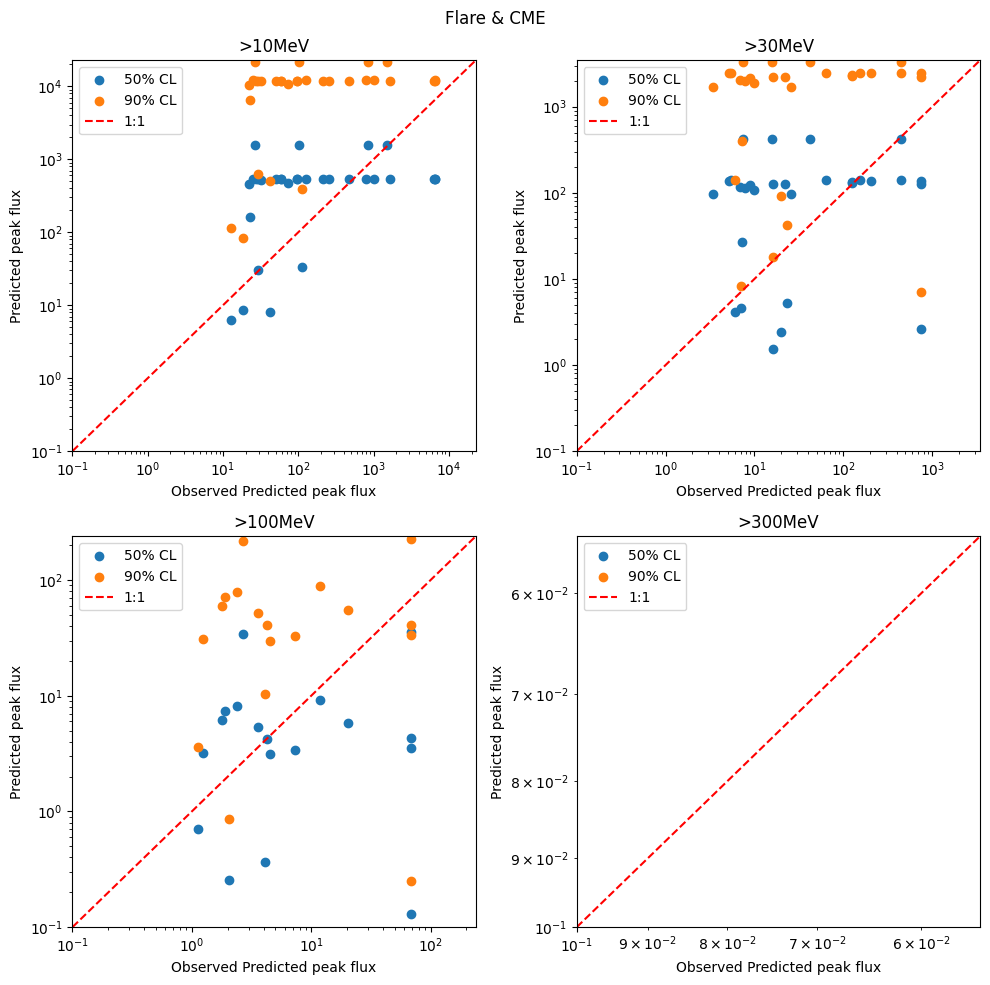

In [20]:
plot_obs_pred_pf()

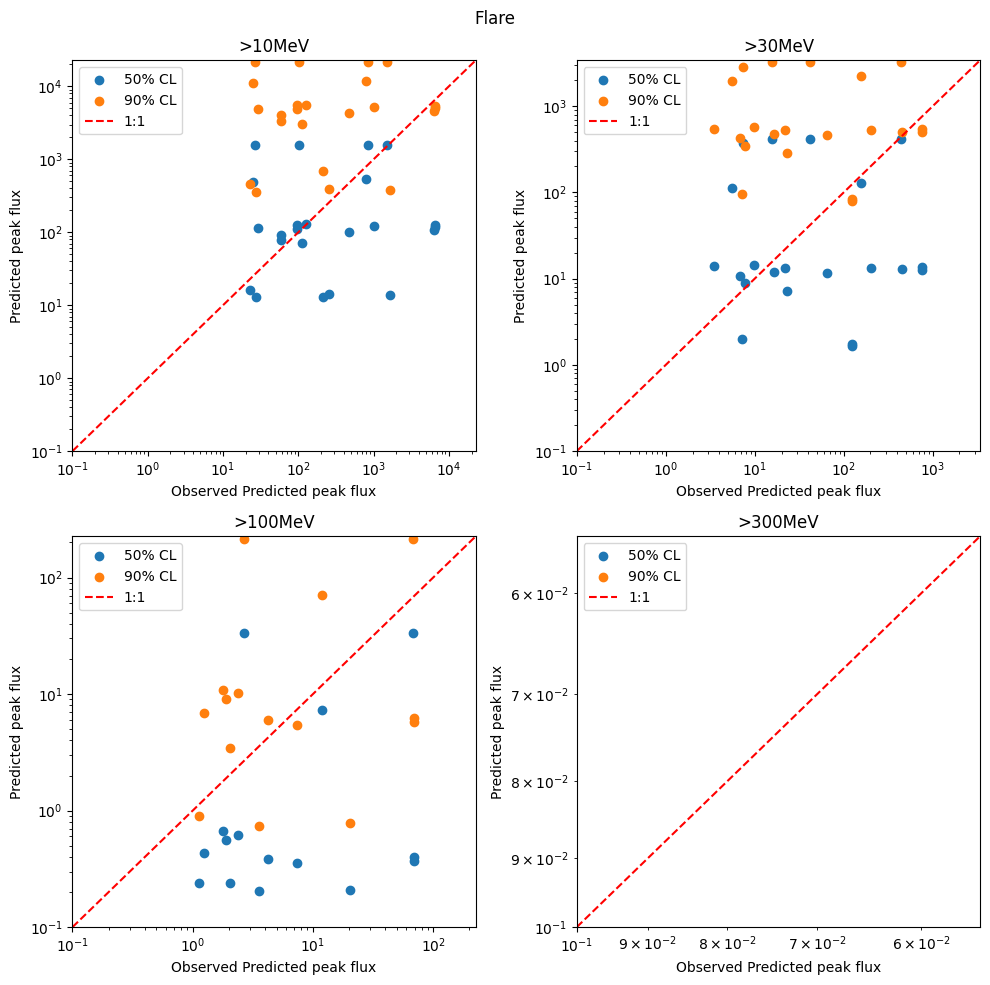

In [21]:
plot_obs_pred_pf("flare")

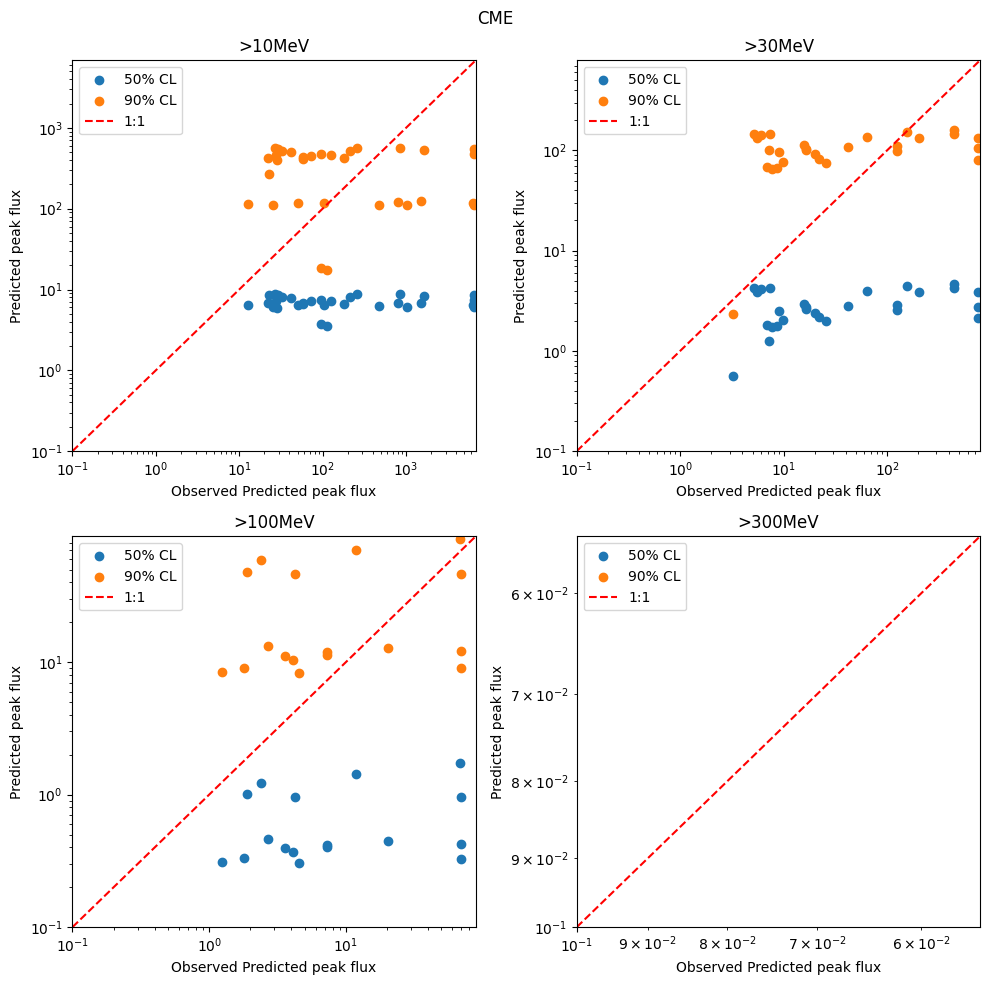

In [22]:
plot_obs_pred_pf("cme")